In [1]:
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import requests
from bs4 import BeautifulSoup
import time
from tqdm.notebook import tqdm
import re
from urllib.request import urlopen
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

## 1.スクレイピング

## 封印

In [3]:

def scrape_race_results(race_id_list, pre_race_results={}):
    #race_results = pre_race_results
    race_results = pre_race_results.copy() #正しくはこちら。注意点で解説。
    for race_id in tqdm(race_id_list):
        if race_id in race_results.keys():
            continue
        try:
            time.sleep(1)
            url = "https://db.netkeiba.com/race/" + race_id
            race_results[race_id] = pd.read_html(url)[0]
        except IndexError:
            continue
	#この部分は動画中に無いですが、捕捉できるエラーは拾った方が、エラーが出たときに分かりやすいです
        except Exception as e:
            print(e)
            break
        except:
	        break
    return race_results

#レースIDのリストを作る
race_id_list = []
for place in range(1, 11, 1):
    for kai in range(1, 6, 1):
        for day in range(1, 13, 1):
            for r in range(1, 13, 1):
                race_id = "2019" + str(place).zfill(2) + str(kai).zfill(2) +\
		        str(day).zfill(2) + str(r).zfill(2)
                race_id_list.append(race_id)

#スクレイピングしてデータを保存

test3 = scrape_race_results(race_id_list)
for key in test3: #.keys()は無くても大丈夫です
    test3[key].index = [key] * len(test3[key])
results = pd.concat([test3[key] for key in test3], sort=False) 
results.to_pickle('results_fix.pickle')


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [2]:
url = 'https://db.netkeiba.com/race/201901010101'
pd.read_html(url)[0]

,着順,枠番,馬番,馬名,性齢,斤量,騎手,タイム,着差,単勝,人気,馬体重,調教師
0,1,1,1,ゴルコンダ,牡2,54,ルメール,1:48.3,NaN,1.4,1,518(-16),[東] 木村哲也
1,2,3,3,プントファイヤー,牡2,54,岩田康誠,1:50.1,大,3.5,2,496(-8),[東] 手塚貴久
2,3,4,4,ラグリマスネグラス,牡2,51,団野大成,1:50.9,5,46.6,6,546(+6),[東] 藤沢和雄
3,4,8,9,キタノコドウ,牡2,51,菅原明良,1:51.5,3.1/2,56.8,7,458(-8),[東] 高木登
4,5,5,5,ネモフィラブルー,牡2,54,川島信二,1:51.7,1.1/2,140.3,9,436(0),[西] 矢作芳人
5,6,8,8,マイネルラクスマン,牡2,54,丹内祐次,1:52.1,2.1/2,9.7,3,480(+8),[東] 金成貴史
6,7,2,2,サンモンテベロ,牝2,54,黛弘人,1:52.5,2.1/2,114.7,8,450(+2),[東] 中野栄治
7,8,7,7,エスカレーション,牝2,54,藤岡佑介,1:52.5,アタマ,26.1,5,448(-4),[東] 高柳瑞樹
8,9,6,6,セイウンジュリア,牝2,54,池添謙一,1:52.6,クビ,16.4,4,470(0),[西] 浅見秀一


## 関数定義

In [350]:
#pickleデータの読み込み
#results = pd.read_pickle('results.pickle')
results2 = pd.read_pickle('results_addinfo.pickle')
#データの分別
def preprocessing(results):
    df = results.copy()

    # 着順に数字以外の文字列が含まれているものを取り除く
    df = df[~(df["着順"].astype(str).str.contains("\D"))]
    df["着順"] = df["着順"].astype(int)

    # 性齢を性と年齢に分ける
    df["性"] = df["性齢"].map(lambda x: str(x)[0])
    df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

    # 馬体重を体重と体重変化に分ける
    df["体重"] = df["馬体重"].str.split("(", expand=True)[0].astype(int)
    df["体重変化"] = df["馬体重"].str.split("(", expand=True)[1].str[:-1].astype(int)

    # データをint, floatに変換
    df["単勝"] = df["単勝"].astype(float)
    df["course_len"] = df["course_len"].astype(int)

    # 不要な列を削除
    df.drop(["タイム", "着差", "調教師", "性齢", "馬体重"], axis=1, inplace=True)

    #新しい規格
    df['date'] = pd.to_datetime(df['date'],format='%Y年%m月%d日')

    return df

#ダミーデータの生成
def split_data(df,test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):]
    train = df.loc[train_id_list]
    test = df.loc[test_id_list]
    return train,test

## results2に移行

In [46]:
results = preprocessing(results)
results

,着順,枠番,馬番,馬名,斤量,騎手,単勝,人気,性,年齢,体重,体重変化
201901010101,1,1,1,ゴルコンダ,54.0,ルメール,1.4,1.0,牡,2,518,-16
201901010101,2,3,3,プントファイヤー,54.0,岩田康誠,3.5,2.0,牡,2,496,-8
201901010101,3,4,4,ラグリマスネグラス,51.0,団野大成,46.6,6.0,牡,2,546,6
201901010101,4,8,9,キタノコドウ,51.0,菅原明良,56.8,7.0,牡,2,458,-8
201901010101,5,5,5,ネモフィラブルー,54.0,川島信二,140.3,9.0,牡,2,436,0
...,...,...,...,...,...,...,...,...,...,...,...,...
201910021212,12,6,11,スリープレッピー,56.0,森裕太朗,120.3,15.0,セ,6,458,8
201910021212,13,1,1,バリオラージュ,54.0,斎藤新,7.5,4.0,牡,5,460,2
201910021212,14,2,3,サンライズアミーゴ,54.0,亀田温心,99.2,12.0,牡,4,478,14
201910021212,15,6,12,トロハ,52.0,武豊,17.5,8.0,牝,3,468,2


In [166]:
#各データの種類
results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47574 entries, 201901010101 to 201910021212
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   着順      47574 non-null  object 
 1   枠番      47574 non-null  int64  
 2   馬番      47574 non-null  int64  
 3   馬名      47574 non-null  object 
 4   性齢      47574 non-null  object 
 5   斤量      47574 non-null  float64
 6   騎手      47574 non-null  object 
 7   タイム     47122 non-null  object 
 8   着差      43668 non-null  object 
 9   単勝      47574 non-null  object 
 10  人気      47345 non-null  float64
 11  馬体重     47574 non-null  object 
 12  調教師     47574 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 5.1+ MB


In [48]:
#4着以下を全て4にする
clip_rank = lambda x: x if x < 4 else 4
#動画中のresultsは、preprocessing関数で前処理が行われた後のデータ
results["rank"] = results["着順"].map(clip_rank)
results.drop(["着順", "馬名"], axis=1, inplace=True)

#カテゴリ変数をダミー変数化
results_d = pd.get_dummies(results)
results_d

,枠番,馬番,斤量,単勝,人気,年齢,体重,体重変化,rank,騎手_アヴドゥ,...,騎手_高田潤,騎手_高野和馬,騎手_鮫島克駿,騎手_鮫島良太,騎手_黒岩悠,騎手_黛弘人,騎手_Ｍ．デム,性_セ,性_牝,性_牡
201901010101,1,1,54.0,1.4,1.0,2,518,-16,1,0,...,0,0,0,0,0,0,0,0,0,1
201901010101,3,3,54.0,3.5,2.0,2,496,-8,2,0,...,0,0,0,0,0,0,0,0,0,1
201901010101,4,4,51.0,46.6,6.0,2,546,6,3,0,...,0,0,0,0,0,0,0,0,0,1
201901010101,8,9,51.0,56.8,7.0,2,458,-8,4,0,...,0,0,0,0,0,0,0,0,0,1
201901010101,5,5,54.0,140.3,9.0,2,436,0,4,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201910021212,6,11,56.0,120.3,15.0,6,458,8,4,0,...,0,0,0,0,0,0,0,1,0,0
201910021212,1,1,54.0,7.5,4.0,5,460,2,4,0,...,0,0,0,0,0,0,0,0,0,1
201910021212,2,3,54.0,99.2,12.0,4,478,14,4,0,...,0,0,0,0,0,0,0,0,0,1
201910021212,6,12,52.0,17.5,8.0,3,468,2,4,0,...,0,0,0,0,0,0,0,0,1,0


In [53]:
#訓練データとテストデータに分ける
from sklearn.model_selection import train_test_split

X = results_d.drop(["rank"], axis=1)
y = results_d["rank"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=0
)

#アンダーサンプリング
from imblearn.under_sampling import RandomUnderSampler

rank_1 = y_train.value_counts()[1]
rank_2 = y_train.value_counts()[2]
rank_3 = y_train.value_counts()[3]

rus = RandomUnderSampler(
    #ratio={1: rank_1, 2: rank_2, 3: rank_3, 4: rank_1},
    sampling_strategy={1: rank_1, 2: rank_2, 3: rank_3, 4: rank_1},
    random_state=71
)

#X_train_rus, y_train_rus = rus.fit_sample(X_train.values, y_train.values)
X_train_rus, y_train_rus = rus.fit_resample(X_train.values, y_train.values)
#データの分布
pd.Series(y_train_rus).value_counts()

1    2420
4    2420
3    2417
2    2414
dtype: int64

In [59]:
#訓練
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_rus, y_train_rus)

#スコアを表示
print(model.score(X_train, y_train), model.score(X_test, y_test))


0.564004608574374 0.5614742501414828


/home/hoshi/.local/share/virtualenvs/keiba-pS9ZwPw7/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/hoshi/.local/share/virtualenvs/keiba-pS9ZwPw7/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/hoshi/.local/share/virtualenvs/keiba-pS9ZwPw7/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [55]:
#予想パターン
pd.Series(y_pred).value_counts()

4    7507
1    3524
3    1689
2    1416
dtype: int64

In [56]:
#一着と予想したうちの予測結果を確認
y_pred = model.predict(X_test)
pred_df = pd.DataFrame({"pred": y_pred, "actual": y_test})
pred_df[pred_df["pred"] == 1]["actual"].value_counts()

/home/hoshi/.local/share/virtualenvs/keiba-pS9ZwPw7/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


4    1754
1     684
2     612
3     474
Name: actual, dtype: int64

In [64]:
#回帰係数の確認
coefs = pd.Series(model.coef_[0], index=X.columns).sort_values()
coefs[["枠番", "馬番", "斤量", "単勝", "人気", "年齢", "体重", "体重変化"]]

枠番     -0.003471
馬番      0.002468
斤量      0.004374
単勝     -0.008761
人気     -0.104455
年齢     -0.021528
体重      0.001070
体重変化   -0.000820
dtype: float64

## 2.ランダムフォレスト

In [92]:
#時系列を正す
import requests
from bs4 import BeautifulSoup

race_id = "201901010101"
url = "https://db.netkeiba.com/race/" + race_id
html = requests.get(url)
html.encoding = "EUC-JP"
soup =BeautifulSoup(html.text,"html.parser")

In [95]:
text = soup.find("div",attrs = {'class':'data_intro'}).find_all('p')[0].text

#正規表現の取り出し
import re
re.findall(r'\w+',text)

['芝右1800m', '天候', '曇', '芝', '良', '発走', '09', '50']

In [129]:
#スクレイピングする対象
race_id_list = results.index.unique()

In [130]:
#レース条件のデータ取り出し関数
def scrape_race_info(race_id_list):
    race_infos={}

    for race_id in tqdm(race_id_list):
        try:
            url = 'https://db.netkeiba.com/race/' + race_id
            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text,'html.parser')

            texts = soup.find("div",attrs = {'class':'data_intro'}).find_all('p')[0].text + \
                soup.find("div",attrs = {'class':'data_intro'}).find_all('p')[1].text
            info = re.findall(r"\w+",texts)
            info_dict = {}
            for text in info:
                if text in ['芝','ダート']:
                    info_dict['race_type'] = text
                if '障' in text:
                    info_dict['race_type'] = '障害'
                if 'm' in text:
                    info_dict['course_len'] = int(re.findall(r'\d+',text)[0])
                if text in ['良','稍重','重','不良']:
                    info_dict['ground_state'] = text
                if text in ['曇','晴','雨','小雨','小雪','雪']:
                    info_dict['weather'] = text
                if '年' in text:
                    info_dict['date'] = text

            race_infos[race_id] = info_dict
            time.sleep(1)
        except IndexError:
            continue
        except:
            break
    return race_infos


In [647]:
#スクレイピング
race_infos = scrape_race_info(race_id_list)

  0%|          | 0/7200 [00:00<?, ?it/s]

In [146]:
#書き込みtest
race_infos_test2 = pd.read_pickle('results_test.pickle')

In [167]:
#データの結合
results_addinfo = results.merge(race_infos_test,left_index=True,right_index=True,how='inner')

## ここまでのデータはたぶん必要ない

In [288]:
#結合データの書き込み
#results_addinfo
#results_addinfo = pd.concat([test3[key] for key in test3], sort=False) 
results_addinfo.to_pickle('results_addinfo.pickle')

## ここからデータ読み込み

In [338]:
#記録チェック
#results2 = pd.read_pickle('results_addinfo.pickle')
#results2
results2 = preprocessing(results_addinfo)

In [339]:
results2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47118 entries, 201901010101 to 201910021212
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   着順            47118 non-null  int64         
 1   枠番            47118 non-null  int64         
 2   馬番            47118 non-null  int64         
 3   馬名            47118 non-null  object        
 4   斤量            47118 non-null  float64       
 5   騎手            47118 non-null  object        
 6   単勝            47118 non-null  float64       
 7   人気            47118 non-null  float64       
 8   course_len    47118 non-null  int64         
 9   weather       47118 non-null  object        
 10  race_type     47118 non-null  object        
 11  ground_state  47118 non-null  object        
 12  date          47118 non-null  datetime64[ns]
 13  性             47118 non-null  object        
 14  年齢            47118 non-null  int64         
 15  体重            47118 non

In [351]:
#テストデータと訓練データの分割
sorted_id_list = results2.sort_values('date').index.unique()
round(len(sorted_id_list)*0.7)
results_p = results2
train_id_list = sorted_id_list[:round(len(sorted_id_list)*0.7)]
test_id_list = sorted_id_list[round(len(sorted_id_list)*0.7):]
train = results_p.loc[train_id_list]
test = results_p.loc[test_id_list]

In [401]:
#データの割合
#len(train)
#len(test)
#len(results_p)
len(train)/len(results_p)

0.7030646462073942

In [342]:
#ダミーデータの生成
'''
def split_data(df,test_size):
    sorted_id_list = df.sort_values('date').index.unique()
    train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):]
    train = df.loc[train_id_list]
    test = df.loc[test_id_list]
    return train,test
'''

In [343]:
train,test = split_data(results_p)

In [344]:
results_p.drop(['馬名'],axis=1,inplace=True)
results_d = pd.get_dummies(results_p)
results_d['rank'] = results_d['着順'].map(lambda x: x if x < 4 else 4)
train,test = split_data(results_d,0.3)

In [296]:
from imblearn.under_sampling import RandomUnderSampler
#アンダーサンプリング
rank_1 = train['rank'].value_counts()[1]
rank_2 = train['rank'].value_counts()[2]
rank_3 = train['rank'].value_counts()[3]

rus = RandomUnderSampler(
    #ratio={1: rank_1, 2: rank_2, 3: rank_3, 4: rank_1},#ratioは削除されました
    sampling_strategy={1: rank_1, 2: rank_2, 3: rank_3, 4: rank_1},
    random_state=71
)

X_train = train.drop(['着順','date','rank'],axis=1)
y_train = train['rank']
X_test = test.drop(['着順','date','rank'],axis=1)
y_test = test['rank']

#X_train_rus,y_train_rus = rus.fit_sample(X_train,y_train)#fit_sampleに問題あり
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [297]:
#ランダムフォレスト
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train_rus,y_train_rus)

print(clf.score(X_train,y_train),clf.score(X_test,y_test))

0.7229148428774111 0.5393467228932886


## 3.予想モデル

In [497]:
results_addinfo = pd.read_pickle('results_addinfo.pickle')
results2 = preprocessing(results_addinfo)

In [498]:
#テストデータと訓練データの分割
sorted_id_list = results2.sort_values('date').index.unique()
round(len(sorted_id_list)*0.7)
results_p = results2
train_id_list = sorted_id_list[:round(len(sorted_id_list)*0.7)]
test_id_list = sorted_id_list[round(len(sorted_id_list)*0.7):]
train = results_p.loc[train_id_list]
test = results_p.loc[test_id_list]

In [499]:
#results_p['rank'] = results_p['着順'].map(lambda x: x if x < 4 else 4)
#results_p.drop(['着順'],axis=1,inplace=True)

In [500]:
#results_p['rank'].value_counts()

In [501]:
results_p['rank'] = results_p['着順'].map(lambda x: x if x < 4 else 4)
#2回読み込んではいけない
results_p['rank'] = results_p['rank'].map(lambda x: 1 if x < 4 else 0)
results_p['rank'].value_counts()

0    36759
1    10359
Name: rank, dtype: int64

In [502]:
#train,test = split_data(results_p)
#ダミー変数化、二回目は失敗する
results_p.drop(['馬名'],axis=1,inplace=True)
results_d = pd.get_dummies(results_p)

In [503]:
results_p.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47118 entries, 201901010101 to 201910021212
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   着順            47118 non-null  int64         
 1   枠番            47118 non-null  int64         
 2   馬番            47118 non-null  int64         
 3   斤量            47118 non-null  float64       
 4   騎手            47118 non-null  object        
 5   単勝            47118 non-null  float64       
 6   人気            47118 non-null  float64       
 7   course_len    47118 non-null  int64         
 8   weather       47118 non-null  object        
 9   race_type     47118 non-null  object        
 10  ground_state  47118 non-null  object        
 11  date          47118 non-null  datetime64[ns]
 12  性             47118 non-null  object        
 13  年齢            47118 non-null  int64         
 14  体重            47118 non-null  int64         
 15  体重変化          47118 non

In [508]:
train,test = split_data(results_d)

In [568]:
#データの選別
x_train = train.drop(['着順','rank','date'],axis=1)
y_train = train['rank']
x_test = test.drop(['着順','rank','date'],axis=1)
y_test = test['rank']

## 4.ランダムフォレスト

In [570]:
rf = RandomForestClassifier(random_state=100)
rf.fit(x_train,y_train)
#clf = RandomForestClassifier(random_state=0)
#clf.fit(X_train_rus,y_train_rus)
#print(rf.score(X_train,y_train),rf.score(X_test,y_test))

RandomForestClassifier(random_state=100)

In [571]:
y_pred = rf.predict_proba(x_test)[:,1]

In [572]:
y_pred

array([0.44, 0.64, 0.67, ..., 0.02, 0.43, 0.01])

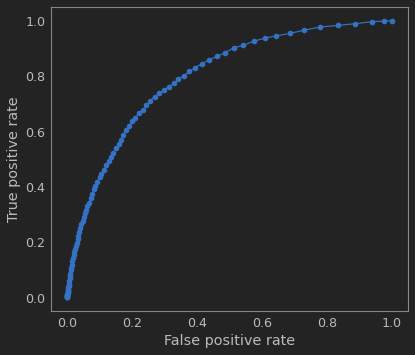

In [573]:
jtplot.style(theme='monokai')

fpr,tpr,thresholds = roc_curve(y_test,y_pred)
plt.plot(fpr,tpr,marker='o')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid()
plt.show()

In [574]:
roc_auc_score(y_test,y_pred)

0.7967149439818251

In [575]:
y_pred_train = y_pred = rf.predict_proba(x_train)[:,1]
roc_auc_score(y_train,y_pred_train)

1.0

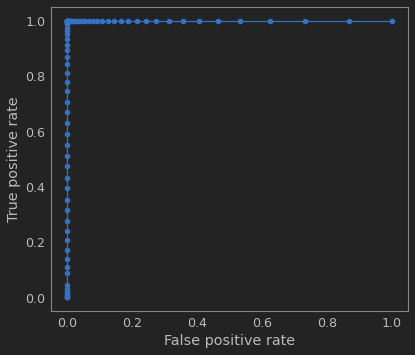

In [576]:
fpr,tpr,thresholds = roc_curve(y_train,y_pred_train)
plt.plot(fpr,tpr,marker='o')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid()
plt.show()

In [578]:
params = {
    'min_samples_split':500,
    'max_depth':None,
    'n_estimators':60,
    'criterion':'entropy',
    'class_weight':'balanced',
    'random_state':100
}

rf = RandomForestClassifier(**params)
rf.fit(x_train,y_train)
y_pred_train = rf.predict_proba(x_train)[:,1]
y_pred = rf.predict_proba(x_test)[:,1]
print(roc_auc_score(y_train,y_pred_train))
print(roc_auc_score(y_test,y_pred))

0.838306524227657
0.8060379740962669


In [581]:
importances = pd.DataFrame({'features':X_train.columns,'importance':rf.feature_importances_})
importances.sort_values('importance',ascending=False)[:20]

,features,importance
3,単勝,0.413439
4,人気,0.360329
7,体重,0.016546
8,体重変化,0.010153
23,騎手_ルメール,0.010110
6,年齢,0.008884
5,course_len,0.007722
97,騎手_川田将雅,0.007667
1,馬番,0.007571
2,斤量,0.007163


## 5.勾配ブースティング木

In [584]:
params = {
    'num_leaves':4,
    'n_estimators':80,
    #'min_data_in_leaf':15,
    'class_weight':'balanced',
    'random_leaves':100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(x_train.values,y_train.values)
y_pred_train = rf.predict_proba(x_train)[:,1]
y_pred = rf.predict_proba(x_test)[:,1]
print(roc_auc_score(y_train,y_pred_train))
print(roc_auc_score(y_test,y_pred))

0.838306524227657
0.8060379740962669


In [586]:
importances = pd.DataFrame({'features':X_train.columns,'importance':lgb_clf.feature_importances_})
importances.sort_values('importance',ascending=False)[:20]

,features,importance
3,単勝,127
4,人気,24
7,体重,13
6,年齢,10
179,騎手_藤田菜七,8
8,体重変化,7
1,馬番,7
2,斤量,6
27,騎手_上野翔,4
5,course_len,3


## 6.過去のレースデータを入れる

In [679]:
race_id = "201901010101"
url = "https://db.netkeiba.com/race/" + race_id
html = requests.get(url)
html.encoding = "EUC-JP"
soup =BeautifulSoup(html.text,"html.parser")

In [680]:
test = soup.find('table',attrs={'summary':'レース結果'}).find_all("a",attrs={'href':re.compile('^/horse')})

In [685]:
test

[<a href="/horse/2017105318/" id="umalink_201901010101" title="ゴルコンダ">ゴルコンダ</a>,
 <a href="/horse/2017104612/" id="umalink_201901010101" title="プントファイヤー">プントファイヤー</a>,
 <a href="/horse/2017103879/" id="umalink_201901010101" title="ラグリマスネグラス">ラグリマスネグラス</a>,
 <a href="/horse/2017106259/" id="umalink_201901010101" title="キタノコドウ">キタノコドウ</a>,
 <a href="/horse/2017104140/" id="umalink_201901010101" title="ネモフィラブルー">ネモフィラブルー</a>,
 <a href="/horse/2017101930/" id="umalink_201901010101" title="マイネルラクスマン">マイネルラクスマン</a>,
 <a href="/horse/2017100184/" id="umalink_201901010101" title="サンモンテベロ">サンモンテベロ</a>,
 <a href="/horse/2017102953/" id="umalink_201901010101" title="エスカレーション">エスカレーション</a>,
 <a href="/horse/2017102421/" id="umalink_201901010101" title="セイウンジュリア">セイウンジュリア</a>]

In [681]:
#soup.find('table',attrs={'summary':'レース結果'}).find_all("a",attrs={'href':re.compile('^/jockey')})

In [682]:
re.findall(r'\d+',test[0]['href'])

['2017105318']

In [683]:
horse_id_list = []
for a in test:
    horse_id = re.findall(r'\d+',a['href'])
    horse_id_list.append(horse_id[0])

In [684]:
horse_id_list

['2017105318',
 '2017104612',
 '2017103879',
 '2017106259',
 '2017104140',
 '2017101930',
 '2017100184',
 '2017102953',
 '2017102421']

In [8]:

def scrape_race_results2(race_id_list, pre_race_results={}):
    #race_results = pre_race_results
    race_results = pre_race_results.copy() #正しくはこちら。注意点で解説。
    for race_id in tqdm(race_id_list):
        if race_id in race_results.keys():
            continue
        try:
            url = "https://db.netkeiba.com/race/" + race_id
            #race_results[race_id] = pd.read_html(url)[0]
            df = pd.read_html(url)[0]
            #soup = BeautifulSoup(html.text,'html.parser')

            #horse_idとjockey_idをスクレイピング
            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup =BeautifulSoup(html.text,"html.parser")
            #horse_id
            horse_id_list = []
            horse_a_list = soup.find('table',attrs={'summary':'レース結果'}).find_all("a",attrs={'href':re.compile('^/horse')})
            for a in horse_a_list:
                horse_id = re.findall(r'\d+',a['href'])
                horse_id_list.append(horse_id[0])

            #jockey_id
            jockey_id_list = []
            jockey_a_list = soup.find('table',attrs={'summary':'レース結果'}).find_all("a",attrs={'href':re.compile('^/jockey')})
            for a in jockey_a_list:
                jockey_id = re.findall(r'\d+',a['href'])
                jockey_id_list.append(jockey_id[0])

            df['horse_id'] = horse_id_list
            df['fockey_id'] = jockey_id_list
            
            race_results[race_id] = df
            time.sleep(1)
        except IndexError:
            continue
	#この部分は動画中に無いですが、捕捉できるエラーは拾った方が、エラーが出たときに分かりやすいです
        except Exception as e:
            print(e)
            break
        except:
	        break
    return race_results
#レースIDのリストを作る
race_id_list = []
for place in range(1, 11, 1):
    for kai in range(1, 6, 1):
        for day in range(1, 13, 1):
            for r in range(1, 13, 1):
                race_id = "2019" + str(place).zfill(2) + str(kai).zfill(2) +\
		        str(day).zfill(2) + str(r).zfill(2)
                race_id_list.append(race_id)


In [11]:
race_id_list = ['201901010101','201901010102','201901010103']
test = scrape_race_results2(race_id_list)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [10]:
test

NameError: name 'test' is not defined